## Testing NC backboning over time (across 20 years)

Playing around with the module in util (had to write one from scratch as there is no noise corrected function in the backbone module) and different alpha values

In [1]:
import sys
import os
import pandas as pd
import networkx as nx


# add parent directory to path so we can import from util
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# import module from util
from util.nc_backbone import nc_backbone
from util.project import project
from util.get_edge_list import get_edge_list
from util.merge_fams import merge_fams

df = merge_fams('../data/CosciaRios2012_DataBase.csv')
min_year = df['Year'].min()
max_year = df['Year'].max()
families = df.columns[3:]

alpha_value = 0.4
G_backboned = {}
G_original = {}
edges_evol = {'year': [], 'bb_edges': [], 'og_edges': []}

for year in range(min_year, max_year + 1):
    df_year = df[df['Year'] == year]
    adj = project(df_year, on_municipalities=False)
    edge_list = get_edge_list(adj)

    G_original[year] = nx.Graph()
    G_original[year].add_nodes_from(families)
    G_original[year].add_weighted_edges_from(edge_list)

    bb_edge_list = nc_backbone(adj, alpha=alpha_value)

    G_backboned[year] = nx.Graph()
    G_backboned[year].add_nodes_from(families)
    G_backboned[year].add_weighted_edges_from(bb_edge_list)

    edges_evol['year'].append(year)
    edges_evol['bb_edges'].append(nx.density(G_backboned[year]))
    edges_evol['og_edges'].append(nx.density(G_original[year]))
    
df_edges_evol = pd.DataFrame(edges_evol)
df_edges_evol

,year,bb_edges,og_edges
0,1990,0.000000,0.000000
1,1991,0.000000,0.000000
2,1992,0.000000,0.035714
3,1993,0.071429,0.071429
4,1994,0.000000,0.071429
5,1995,0.035714,0.071429
6,1996,0.071429,0.142857
7,1997,0.035714,0.035714
8,1998,0.107143,0.142857
9,1999,0.071429,0.071429


How ideal is the alpha value?  
We don't want to isolate nodes that belong to the connected component before backboning

In [2]:
# Check for isolated nodes
for year in range(1990, 2011):
    isolated_orig = list(nx.isolates(G_original[year]))
    isolated_bb = list(nx.isolates(G_backboned[year]))
    new_isolated = set(isolated_bb) - set(isolated_orig)

    conn_comp_og = nx.number_connected_components(G_original[year])
    conn_comp_bb = nx.number_connected_components(G_backboned[year])

    print(f"{year}: {conn_comp_og} in the original network, {conn_comp_bb} in the backboned network")
    if new_isolated:
        print(f"\t Nodes {new_isolated} became isolated")

1990: 8 in the original network, 8 in the backboned network
1991: 8 in the original network, 8 in the backboned network
1992: 7 in the original network, 8 in the backboned network
	 Nodes {'Zetas', 'Tijuana'} became isolated
1993: 6 in the original network, 6 in the backboned network
1994: 6 in the original network, 8 in the backboned network
	 Nodes {'Golfo', 'Zetas', 'Tijuana'} became isolated
1995: 6 in the original network, 7 in the backboned network
	 Nodes {'Juarez'} became isolated
1996: 5 in the original network, 6 in the backboned network
1997: 7 in the original network, 7 in the backboned network
1998: 4 in the original network, 5 in the backboned network
1999: 6 in the original network, 6 in the backboned network
2000: 5 in the original network, 6 in the backboned network
2001: 3 in the original network, 4 in the backboned network
2002: 4 in the original network, 4 in the backboned network
2003: 2 in the original network, 2 in the backboned network
2004: 1 in the original ne

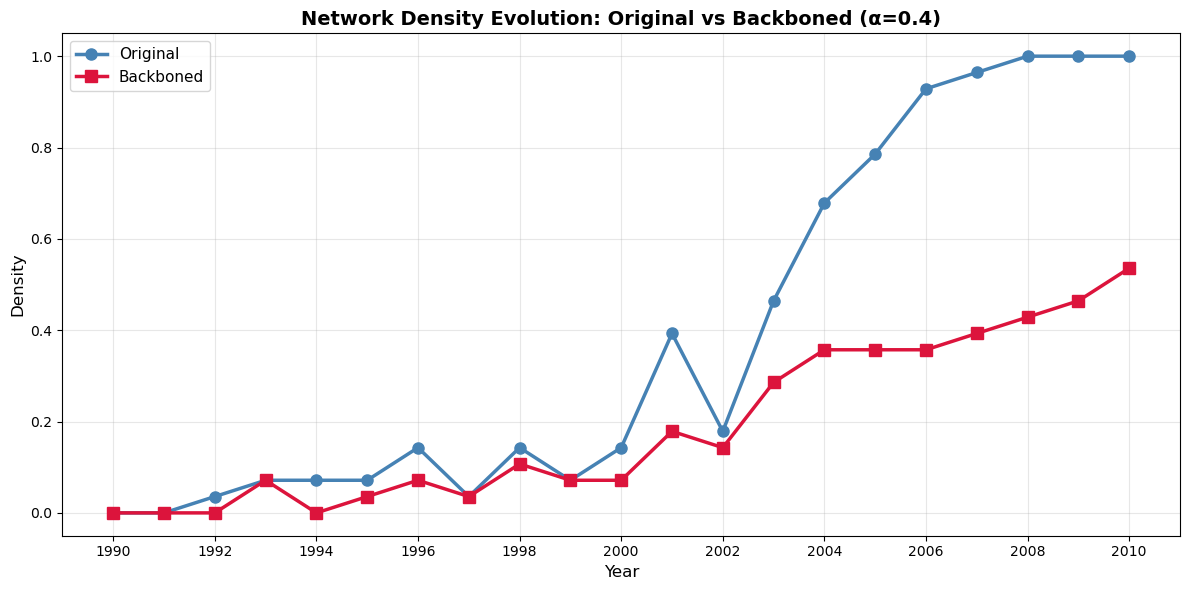

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_edges_evol['year'], df_edges_evol['og_edges'], marker='o', linewidth=2.5, markersize=8, color='steelblue', label='Original')
plt.plot(df_edges_evol['year'], df_edges_evol['bb_edges'], marker='s', linewidth=2.5, markersize=8, color='crimson', label='Backboned')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title(f'Network Density Evolution: Original vs Backboned (α={alpha_value})', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1990, 2011, 2))
plt.tight_layout()
plt.savefig('../presentation/bb_density_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

Smaller (and more reasonable) alpha values lead to very sparse backbones :(  


### Ridiculogram: 

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import imageio
import os

min_year = min(G_backboned.keys())
max_year = max(G_backboned.keys())
max_weight = 189 #hard coded from previous eda cartel projection notebook

G_og_2010 = G_original[2010]

# defining layout once (so positions are consistent across years) - used 2010 network as reference as it's the last state
pos = nx.spring_layout(G_og_2010, weight='weight', seed=42) #nodes with higher weights are closer together

frames = []
temp_dir = "network_frames_fixed_temp"
os.makedirs(temp_dir, exist_ok=True)

for year in range(min_year, max_year + 1):
    G = G_backboned[year]
    year_edges = G.edges()

    # Reuse same node positions but adjust for missing nodes
    nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=500)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

    if len(year_edges) > 0:
        year_weights = np.array(list(G.edges(data='weight')))[:,2].astype(int)
        year_weights = year_weights / max_weight * 5  # normalize for plotting
        nx.draw_networkx_edges(G, pos, edgelist=year_edges, width=year_weights, edge_color="gray", alpha=0.6)    

    plt.title(f"NC Backboned Family Network - Year: {year}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()

    # save year plots in a temporary directory
    fname = os.path.join(temp_dir, f"frame_{year:02d}.png")
    plt.savefig(fname)
    plt.close()
    frames.append(imageio.imread(fname))

# turn all the images in the directory to a gif
imageio.mimsave('../PRESENTATION/bb_network_evolution.gif', frames, fps=2)

# delete images from temporary directory
import shutil
shutil.rmtree(temp_dir)

print("Animation saved as 'bb_network_evolution.gif'")

C:\Users\Maribel ITU\AppData\Local\Temp\ipykernel_14820\2013599106.py:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(fname))


Animation saved as 'bb_network_evolution.gif'


After visually inspecting this backboned projection, we observe some edges appear and disappear depending on the year, in contrast with the original projection where edges stay almost always and only get thicker.

Backboning on collapsed network

Edges in backboned nw: 13


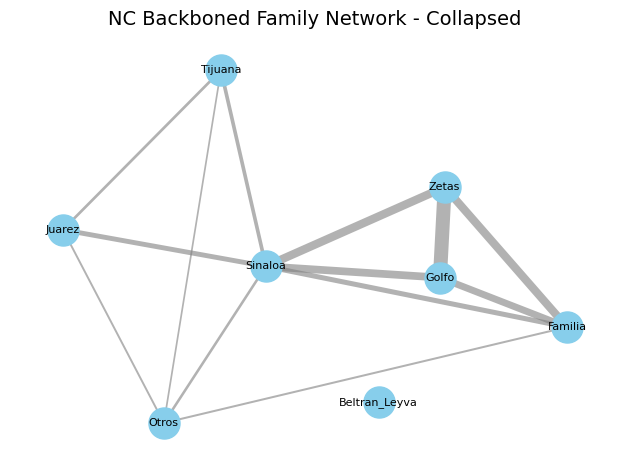

In [5]:
df_collapsed = df.groupby('Code').sum()
df_collapsed = (df_collapsed > 0).astype(int)

collapsed_adj = project(df_collapsed, on_municipalities=False)
collapsed_nc_edge_list = nc_backbone(collapsed_adj, alpha=alpha_value)
G_collapsed = nx.Graph()
G_collapsed.add_nodes_from(families)
G_collapsed.add_weighted_edges_from(collapsed_nc_edge_list)

np.array(G_collapsed.edges(data='weight'))

collapsed_weights = (np.array(list(G_collapsed.edges(data='weight'))))[:,2].astype(int)
collapsed_weights = collapsed_weights / max_weight * 5  # normalize for plotting

nx.draw_networkx_edges(G_collapsed, pos, width=collapsed_weights, edge_color="gray", alpha=0.6)
nx.draw_networkx_nodes(G_collapsed, pos, node_color="skyblue", node_size=500)
nx.draw_networkx_labels(G_collapsed, pos, font_size=8, font_color="black")

print(f"Edges in backboned nw: {G_collapsed.number_of_edges()}")

plt.title(f"NC Backboned Family Network - Collapsed", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

Surprisingly, the nc backboned collapsed network has way less edges than expected for the same alpha value. This suggests that the approach should be to either work with backboned time networks on a specific α or with the collapsed network at another alpha value.

### Stick to timed network
For completeness, we will mainly work with timed data, and compare results to collapsed network to analyze meaningful differences.

### Degree distribution
Plot the cumulative degree distribution from years 2004-2010 (both original and backbone)  
Show that none follow the power law (probably)

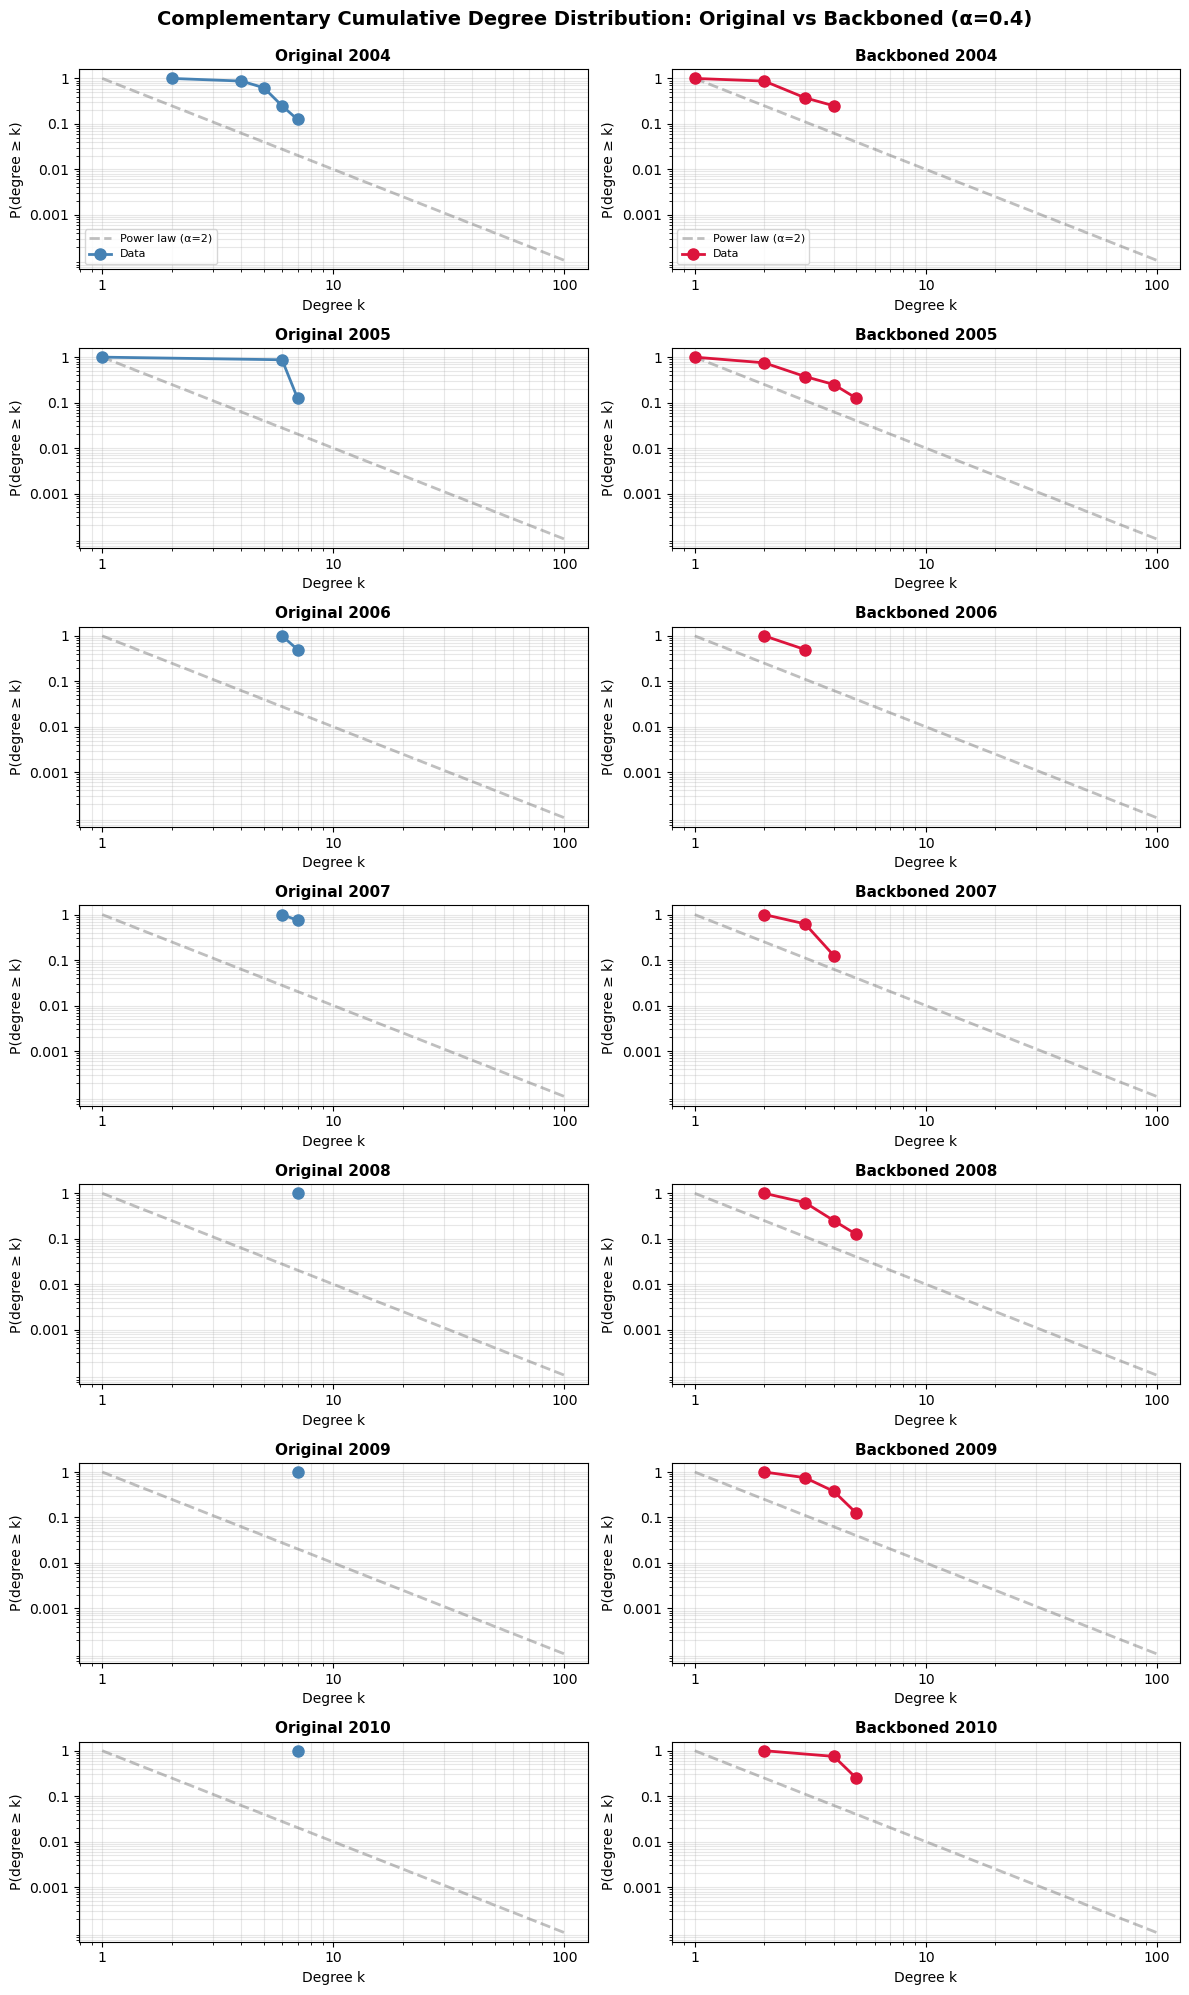

In [6]:
# Create 7x2 plot comparing complementary cumulative degree distributions (optimized)
import numpy as np

years_to_plot = list(range(2004, 2011))
fig, axes = plt.subplots(7, 2, figsize=(12, 20))

# Create reference power law: P(k) = k^(-alpha)
k_ref = np.linspace(1, 100, 100)
power_law_alpha = 2
power_law_ref = k_ref**(-power_law_alpha)  # Power law with exponent -1

for i, year in enumerate(years_to_plot):
    # Original network CCDF (left column)
    ax_orig = axes[i, 0]
    degrees_orig = np.array(list(dict(G_original[year].degree()).values()))
    total_nodes = G_original[year].number_of_nodes()
    
    # Get unique degrees and counts, then compute CCDF efficiently
    unique_degrees, counts = np.unique(degrees_orig, return_counts=True)
    ccdf_orig = np.cumsum(counts[::-1])[::-1] / total_nodes  # reverse cumsum for CCDF
    
    # Plot reference power law first (behind data)
    ax_orig.loglog(k_ref, power_law_ref, '--', color='gray', linewidth=2, alpha=0.5, label=f'Power law (α={power_law_alpha})')
    
    if len(unique_degrees) > 0:
        ax_orig.loglog(unique_degrees, ccdf_orig, 'o-', color='steelblue', markersize=8, linewidth=2, label='Data')
    
    ax_orig.set_xlabel('Degree k', fontsize=10)
    ax_orig.set_ylabel('P(degree ≥ k)', fontsize=10)
    ax_orig.set_title(f'Original {year}', fontsize=11, fontweight='bold')
    ax_orig.grid(True, alpha=0.3, which='both')
    ax_orig.set_xticks([1, 10, 100])
    ax_orig.set_yticks([0.001, 0.01, 0.1, 1])
    ax_orig.set_xticklabels(['1', '10', '100'])
    ax_orig.set_yticklabels(['0.001', '0.01', '0.1', '1'])
    if i == 0:  # Only show legend on first plot
        ax_orig.legend(fontsize=8, loc='lower left')
    
    # Backboned network CCDF (right column)
    ax_bb = axes[i, 1]
    degrees_bb = np.array(list(dict(G_backboned[year].degree()).values()))
    total_nodes_bb = G_backboned[year].number_of_nodes()
    
    # Get unique degrees and counts, then compute CCDF efficiently
    unique_degrees_bb, counts_bb = np.unique(degrees_bb, return_counts=True)
    ccdf_bb = np.cumsum(counts_bb[::-1])[::-1] / total_nodes_bb  # reverse cumsum for CCDF
    
    # Plot reference power law first (behind data)
    ax_bb.loglog(k_ref, power_law_ref, '--', color='gray', linewidth=2, alpha=0.5, label=f'Power law (α={power_law_alpha})')
    
    if len(unique_degrees_bb) > 0:
        ax_bb.loglog(unique_degrees_bb, ccdf_bb, 'o-', color='crimson', markersize=8, linewidth=2, label='Data')
    
    ax_bb.set_xlabel('Degree k', fontsize=10)
    ax_bb.set_ylabel('P(degree ≥ k)', fontsize=10)
    ax_bb.set_title(f'Backboned {year}', fontsize=11, fontweight='bold')
    ax_bb.grid(True, alpha=0.3, which='both')
    ax_bb.set_xticks([1, 10, 100])
    ax_bb.set_yticks([0.001, 0.01, 0.1, 1])
    ax_bb.set_xticklabels(['1', '10', '100'])
    ax_bb.set_yticklabels(['0.001', '0.01', '0.1', '1'])
    if i == 0:  # Only show legend on first plot
        ax_bb.legend(fontsize=8, loc='lower left')

plt.suptitle(f'Complementary Cumulative Degree Distribution: Original vs Backboned (α={alpha_value})', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../presentation/ccdf_k_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Impossible to state there is any kind of power law behavior, as the small number of nodes N limits the exponential behavior: the degree k has a max value of 9 and the power law follows the structure:
p(k) ~ k^(-α), meaning that as k → inf, p → 0. Besides, most nodes in the network have a degree of 1 as most real word networks are sparse, but in this case they are usually very dense. We tested at α=2 because real world power law networks have 2 ≤ α ≤ 5. What we can see that the backboning did a good job in removing edges such that nodes have more diverse degrees. 

**Better wording: With 𝑁 = 10, the degree distribution has no asymptotic regime, making any claim of power-law behavior or cutoff meaningless; the observed CCDF curvature is entirely due to finite-size constraints**

---

### Edge weight distribution
Plot the cumulative degree distribution from years 2004-2010 (both original and backbone)  
Show that none follow the power law (probably)

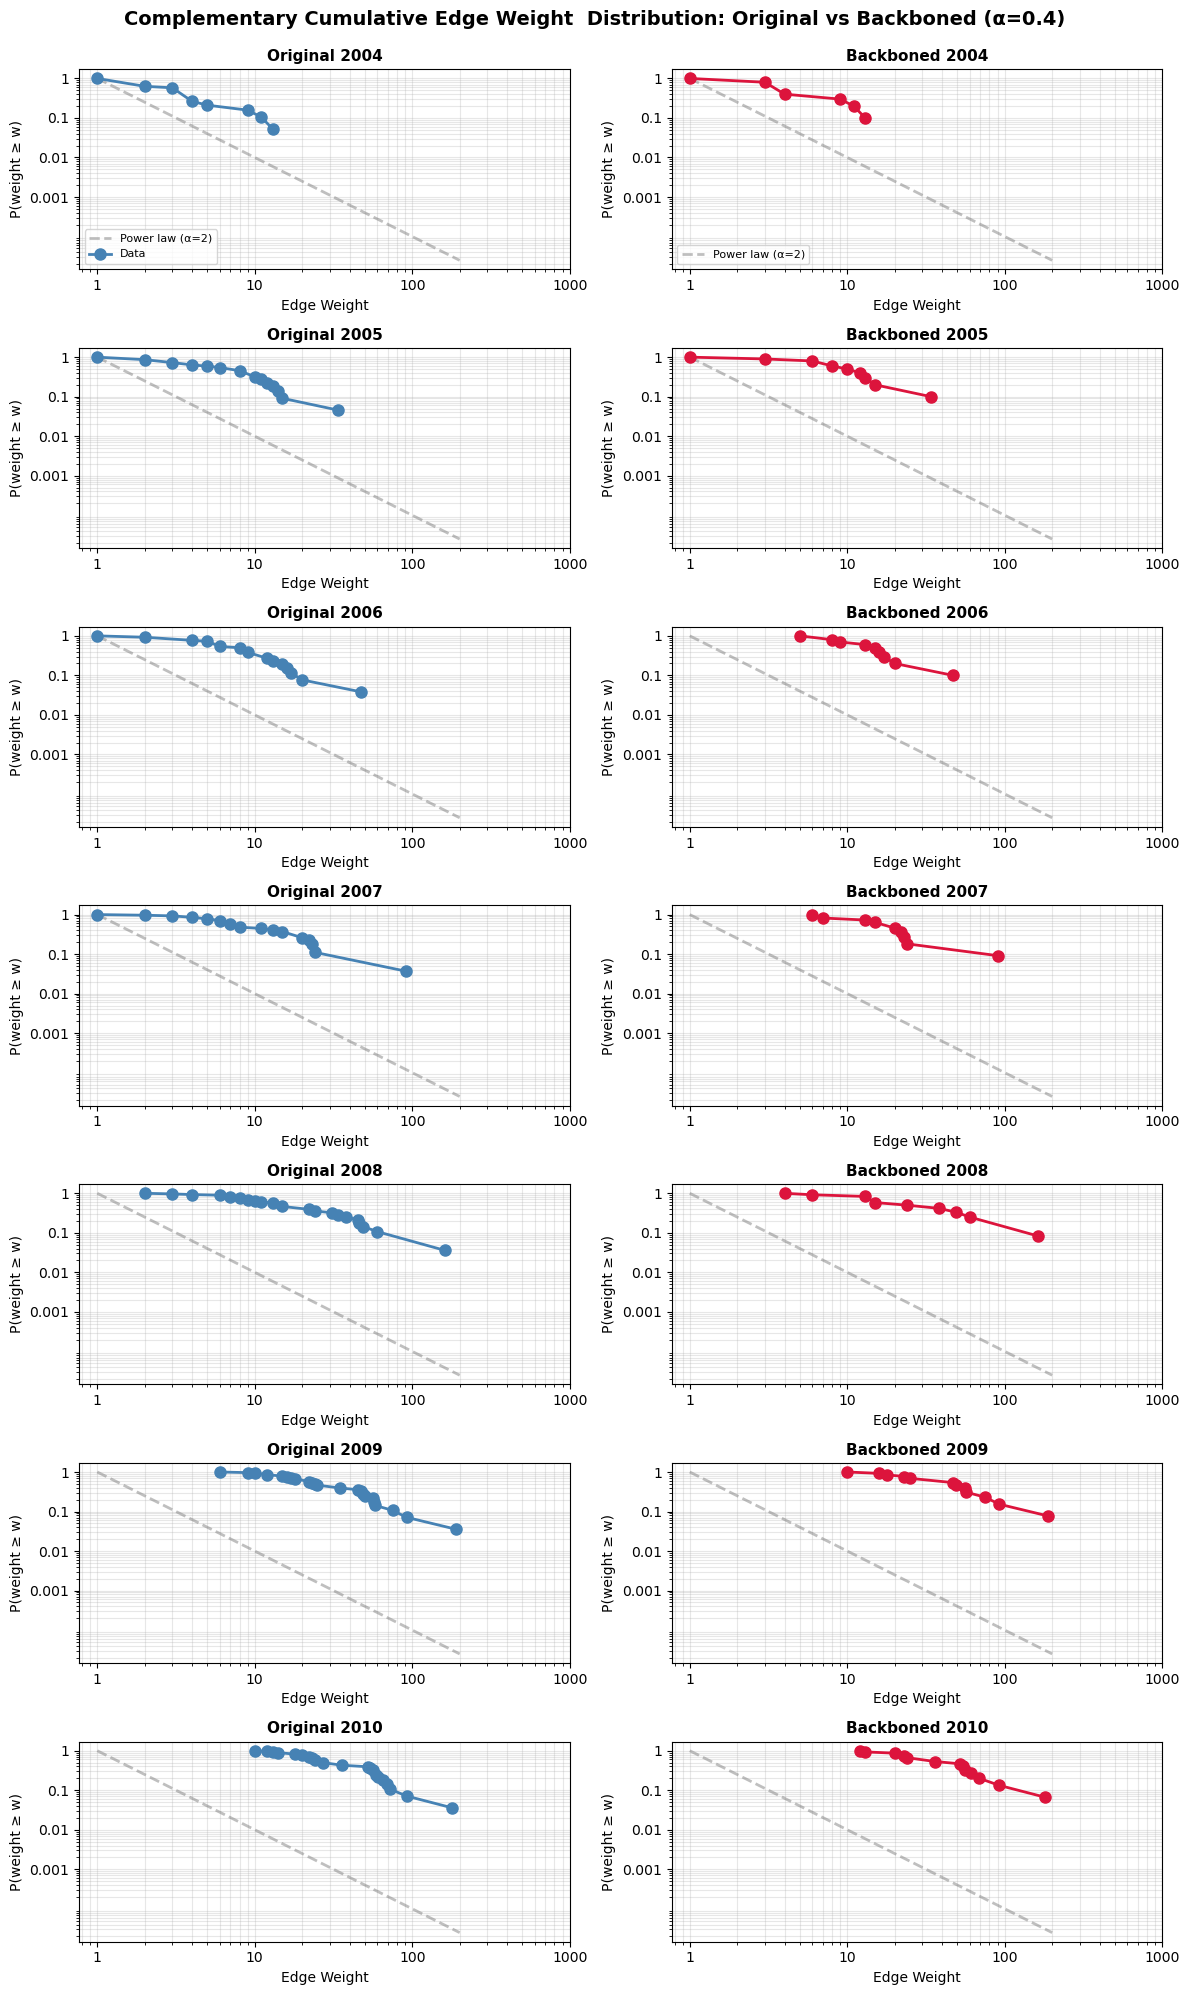

In [7]:
# Create 7x2 plot comparing complementary cumulative degree distributions (optimized)
import numpy as np

years_to_plot = list(range(2004, 2011))
fig, axes = plt.subplots(7, 2, figsize=(12, 20))

# Create reference power law for edge weights
w_ref = np.linspace(1, 200, 200)
power_law_alpha = 2
power_law_ref = w_ref**(-power_law_alpha)

for i, year in enumerate(years_to_plot):
    # Original network CCDF (left column)
    ax_orig = axes[i, 0]
    weights_orig = np.array(list(G_original[year].edges(data='weight')))[:,2].astype(int)
    total_edges = len(weights_orig)
    
    # Get unique weights and counts, then compute CCDF efficiently
    unique_weights, counts = np.unique(weights_orig, return_counts=True)
    ccdf_orig = np.cumsum(counts[::-1])[::-1] / total_edges  # reverse cumsum for CCDF

    # Plot reference power law first (behind data)
    ax_orig.loglog(w_ref, power_law_ref, '--', color='gray', linewidth=2, alpha=0.5, label=f'Power law (α={power_law_alpha})')
    
    if len(unique_weights) > 0:
        ax_orig.loglog(unique_weights, ccdf_orig, 'o-', color='steelblue', markersize=8, linewidth=2, label='Data')
    
    ax_orig.set_xlabel('Edge Weight', fontsize=10)
    ax_orig.set_ylabel('P(weight ≥ w)', fontsize=10)
    ax_orig.set_title(f'Original {year}', fontsize=11, fontweight='bold')
    ax_orig.grid(True, alpha=0.3, which='both')
    ax_orig.set_xticks([1, 10, 100, 1000])
    ax_orig.set_yticks([0.001, 0.01, 0.1, 1])
    ax_orig.set_xticklabels(['1', '10', '100', '1000'])
    ax_orig.set_yticklabels(['0.001', '0.01', '0.1', '1'])
    if i == 0:  # Only show legend on first plot
        ax_orig.legend(fontsize=8, loc='lower left')
    
    # Backboned network CCDF (right column)
    ax_bb = axes[i, 1]
    weights_bb = np.array(list(G_backboned[year].edges(data='weight')))[:,2].astype(int)
    total_edges_bb = len(weights_bb)
    
    # Get unique weights and counts, then compute CCDF efficiently
    unique_weights_bb, counts_bb = np.unique(weights_bb, return_counts=True)
    ccdf_bb = np.cumsum(counts_bb[::-1])[::-1] / total_edges_bb  # reverse cumsum for CCDF

    # Plot reference power law first (behind data)
    ax_bb.loglog(w_ref, power_law_ref, '--', color='gray', linewidth=2, alpha=0.5, label=f'Power law (α={power_law_alpha})')
    
    if len(unique_weights_bb) > 0:
        ax_bb.loglog(unique_weights_bb, ccdf_bb, 'o-', color='crimson', markersize=8, linewidth=2)
    
    ax_bb.set_xlabel('Edge Weight', fontsize=10)
    ax_bb.set_ylabel('P(weight ≥ w)', fontsize=10)
    ax_bb.set_title(f'Backboned {year}', fontsize=11, fontweight='bold')
    ax_bb.grid(True, alpha=0.3, which='both')
    ax_bb.set_xticks([1, 10, 100, 1000])
    ax_bb.set_yticks([0.001, 0.01, 0.1, 1])
    ax_bb.set_xticklabels(['1', '10', '100', '1000'])
    ax_bb.set_yticklabels(['0.001', '0.01', '0.1', '1'])
    if i == 0:  # Only show legend on first plot
        ax_bb.legend(fontsize=8, loc='lower left')

plt.suptitle(f'Complementary Cumulative Edge Weight  Distribution: Original vs Backboned (α={alpha_value})', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../presentation/ccdf_w_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Even though the weight value is not as limited as the degree value (which is max k=9), the power law distribution for edge weights is limited by the small sample size, where we have 45 weight values in the best case (when the network is a clique). So, we can't say this follows a power law distribution either.
What we can mention is that the backboning is removing noisy edges, and in many cases the low weighted edges so the edge weight distribution becomes more shifted to the right.

---

### Diameter, APL, Density, CC
Plot each measurement's evolution over 1990-2010 for both versions (original network and backboned) and see how they diverge

#### Diameter

In [8]:
diam_evol = {'year': [], 'bb_diam': [], 'og_diam': []}

for year in range(min_year, max_year + 1):
    diam_evol['year'].append(year)

    # Original network diameter
    if nx.is_connected(G_original[year]):
        diam_evol['og_diam'].append(nx.diameter(G_original[year]))
    else:
        # Get largest connected component
        lcc_og = max(nx.connected_components(G_original[year]), key=len)
        G_lcc_og = G_original[year].subgraph(lcc_og)
        diam_evol['og_diam'].append(nx.diameter(G_lcc_og))
    
    # Backboned network diameter
    if nx.is_connected(G_backboned[year]):
        diam_evol['bb_diam'].append(nx.diameter(G_backboned[year]))
    else:
        # Get largest connected component
        lcc_bb = max(nx.connected_components(G_backboned[year]), key=len)
        G_lcc_bb = G_backboned[year].subgraph(lcc_bb)
        diam_evol['bb_diam'].append(nx.diameter(G_lcc_bb))
    
df_diam_evol = pd.DataFrame(diam_evol)
df_diam_evol

,year,bb_diam,og_diam
0,1990,0,0
1,1991,0,0
2,1992,0,1
3,1993,1,1
4,1994,0,2
5,1995,1,2
6,1996,1,2
7,1997,1,1
8,1998,2,3
9,1999,1,1


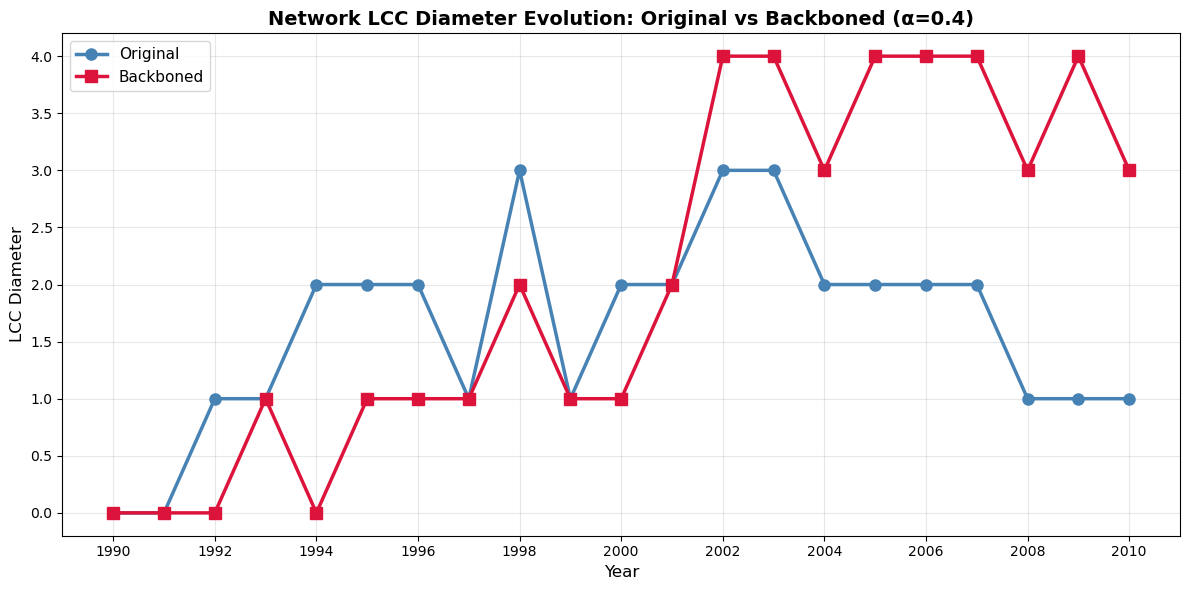

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_diam_evol['year'], df_diam_evol['og_diam'], marker='o', linewidth=2.5, markersize=8, color='steelblue', label='Original')
plt.plot(df_diam_evol['year'], df_diam_evol['bb_diam'], marker='s', linewidth=2.5, markersize=8, color='crimson', label='Backboned')

plt.xlabel('Year', fontsize=12)
plt.ylabel('LCC Diameter', fontsize=12)
plt.title(f'Network LCC Diameter Evolution: Original vs Backboned (α={alpha_value})', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1990, 2011, 2))
plt.tight_layout()
plt.savefig('../presentation/bb_density_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

It makes sense that the diameter stays high in the backboned version, since it reveals more significant structures, and not all families stay connected if their connection is noisy.

#### APL

In [10]:
APL_evol = {'year': [], 'bb_apl': [], 'og_apl': []}

for year in range(min_year, max_year + 1):
    APL_evol['year'].append(year)

    # Original network APL
    if nx.is_connected(G_original[year]):
        og_apl = nx.average_shortest_path_length((G_original[year]))
    else:
        # Get largest connected component
        lcc_og = max(nx.connected_components(G_original[year]), key=len)
        G_lcc_og = G_original[year].subgraph(lcc_og)
        og_apl = nx.average_shortest_path_length(G_lcc_og)

    APL_evol['og_apl'].append(og_apl)
    
    # Backboned network APL
    if nx.is_connected(G_backboned[year]):
        bb_apl = nx.average_shortest_path_length((G_backboned[year]))
    else:
        # Get largest connected component
        lcc_bb = max(nx.connected_components(G_backboned[year]), key=len)
        G_lcc_bb = G_backboned[year].subgraph(lcc_bb)
        bb_apl = nx.average_shortest_path_length(G_lcc_bb)

    APL_evol['bb_apl'].append(bb_apl)
    
df_apl_evol = pd.DataFrame(APL_evol)
df_apl_evol

,year,bb_apl,og_apl
0,1990,0.000000,0.000000
1,1991,0.000000,0.000000
2,1992,0.000000,1.000000
3,1993,1.000000,1.000000
4,1994,0.000000,1.333333
5,1995,1.000000,1.333333
6,1996,1.000000,1.333333
7,1997,1.000000,1.000000
8,1998,1.333333,1.800000
9,1999,1.000000,1.000000


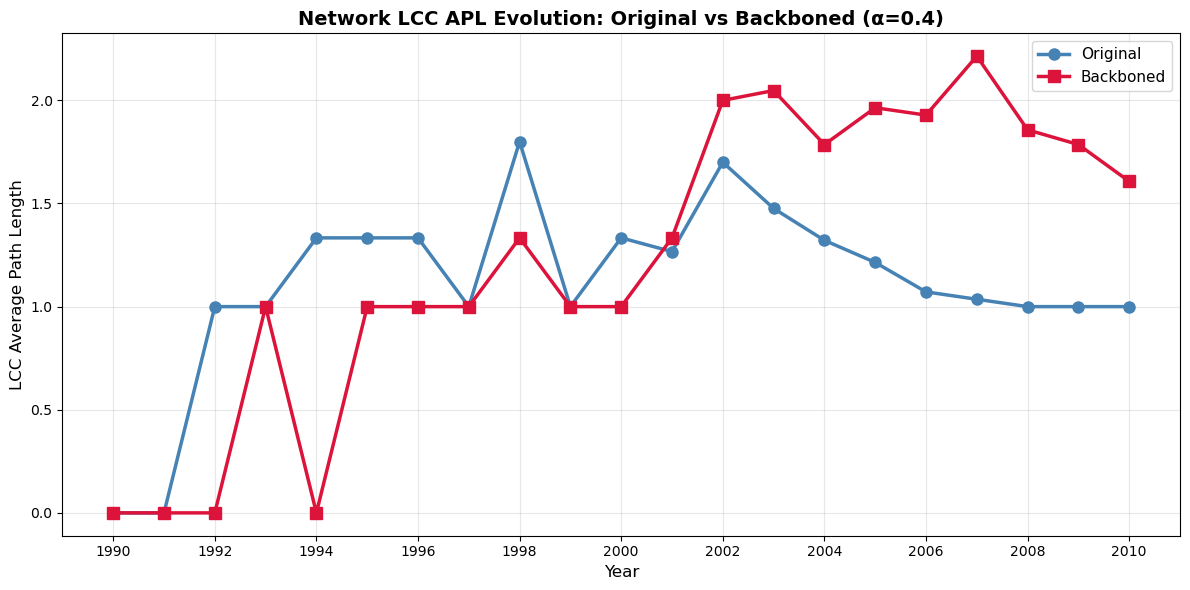

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_apl_evol['year'], df_apl_evol['og_apl'], marker='o', linewidth=2.5, markersize=8, color='steelblue', label='Original')
plt.plot(df_apl_evol['year'], df_apl_evol['bb_apl'], marker='s', linewidth=2.5, markersize=8, color='crimson', label='Backboned')

plt.xlabel('Year', fontsize=12)
plt.ylabel('LCC Average Path Length', fontsize=12)
plt.title(f'Network LCC APL Evolution: Original vs Backboned (α={alpha_value})', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1990, 2011, 2))
plt.tight_layout()
plt.savefig('../presentation/bb_apl_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

#### Diameter & APL: Structural Evolution Analysis

---

### 2007: Maximum Fragmentation

**Network Characteristics:**
- **Highest APL:** 2.17
- **Highest Diameter:** 4
- **Most aggressive edge filtering**

**Hypothesis - Evenly Distributed Co-occurrence:**

The 2007 spike reveals a network with uniform, weak territorial overlap:
- Most family pairs had similar low-to-moderate territorial overlap
- Few very strong ties to anchor the network
- NC test removed most edges → sparse, chain-like backbone
- Families connected through intermediaries rather than directly
- Network became highly hierarchical/modular

**Interpretation:**  
2007 marks a **transitional period** where no clear territorial dominance existed. The uniform weight distribution suggests families were competing for control with similar (weak) strength, leading to maximum structural fragmentation when noise is removed.

---

### 2010: Concentrated Strength

**Network Characteristics:**
- **Lower APL:** 1.60 (despite elevated diameter)
- **More edges retained** (higher density than 2007)
- **Strong core + weak periphery structure**

**Hypothesis - Concentrated Weight Distribution:**

The 2010 network shows consolidation of power:
- A few family pairs dominated territorial overlap (high weights → passed NC test)
- Many moderate ties also survived filtering
- Result: denser backbone with clear hierarchical structure
- Some families emerged as dominant players with strong alliances

**Interpretation:**  
By 2010, the network had **consolidated** into a more integrated structure. The heterogeneous weight distribution indicates winner-take-all dynamics where powerful families established strong coalitions, while maintaining strategic moderate ties with others.

---

### Historical Context: Mexican Drug War Timeline

| Period | Structural Pattern | Socio-political Interpretation |
|--------|-------------------|-------------------------------|
| **2004-2006** | Moderate APL/Diameter | Emerging territorial competition |
| **2007** | **Peak fragmentation** (APL=2.17, d=4) | War for territorial control; no dominant alliances |
| **2008-2010** | Consolidation (APL↓, d stable) | Winner-take-all dynamics; strong coalitions formed |

**Key Insight:** The 2007 spike is the **structural signature** of the Mexican Drug War's escalation period (2006-2008), capturing the transition from distributed conflict to concentrated power.


---
#### Avg CC 
We want to answer the question: how are new connections added over time? do they tend to close triads?

In [12]:
avg_cc_evol = {'year': [], 'bb_avg_cc': [], 'og_avg_cc': []}

for year in range(min_year, max_year + 1):
    avg_cc_evol['year'].append(year)

    # Original network average clustering coefficient (weighted)
    og_avg_cc = nx.average_clustering(G_original[year])
    avg_cc_evol['og_avg_cc'].append(og_avg_cc)
    
    # Backboned network average clustering coefficient (weighted)
    bb_avg_cc = nx.average_clustering(G_backboned[year])
    avg_cc_evol['bb_avg_cc'].append(bb_avg_cc)
    
df_cc_evol = pd.DataFrame(avg_cc_evol)
df_cc_evol

,year,bb_avg_cc,og_avg_cc
0,1990,0.000000,0.000000
1,1991,0.000000,0.000000
2,1992,0.000000,0.000000
3,1993,0.000000,0.000000
4,1994,0.000000,0.000000
5,1995,0.000000,0.000000
6,1996,0.000000,0.291667
7,1997,0.000000,0.000000
8,1998,0.000000,0.000000
9,1999,0.000000,0.000000


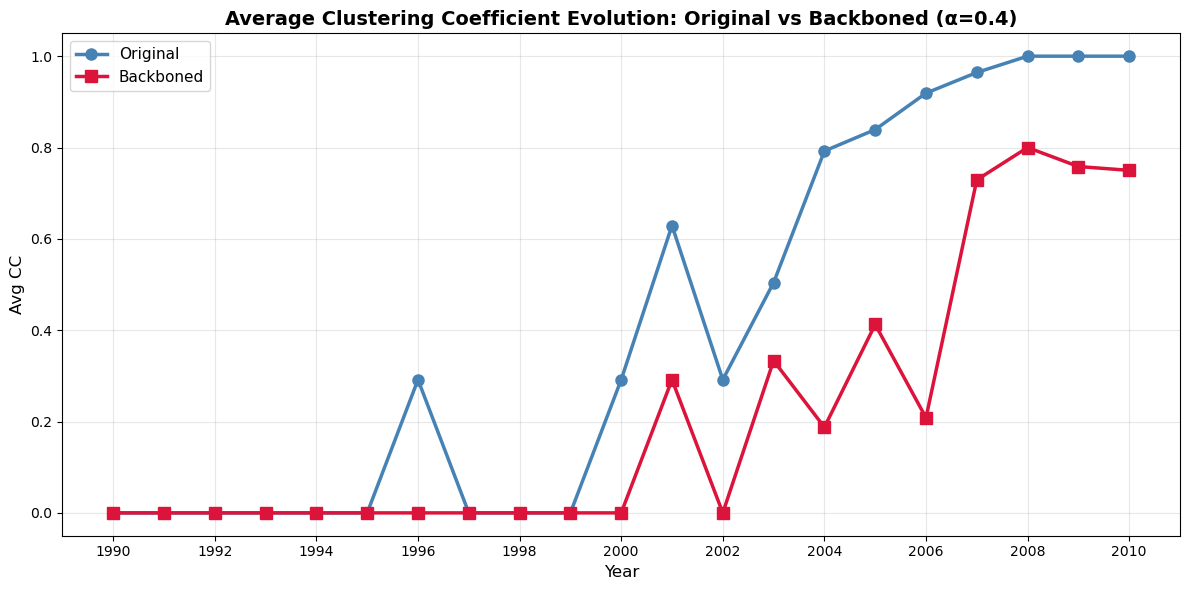

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_cc_evol['year'], df_cc_evol['og_avg_cc'], marker='o', linewidth=2.5, markersize=8, color='steelblue', label='Original')
plt.plot(df_cc_evol['year'], df_cc_evol['bb_avg_cc'], marker='s', linewidth=2.5, markersize=8, color='crimson', label='Backboned')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Avg CC', fontsize=12)
plt.title(f'Average Clustering Coefficient Evolution: Original vs Backboned (α={alpha_value})', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1990, 2011, 2))
plt.tight_layout()
plt.savefig('../presentation/bb_avg_cc_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

### Clustering Coefficient Evolution: Interpretation

---

#### 2004: High CC Despite Moderate Density → Strategic Coalition Testing

**Observed Pattern:**
- **Original Network:** Density = 0.68, Average CC = 0.79
- **Backboned Network:** Density = 0.36 (-47%), Average CC = 0.19 (-76%)

**What This Reveals:**

1. **Preferential Triadic Closure (Alliance Behavior)**
   - When families formed new territorial overlaps in 2004, they preferentially closed triangles
   - High CC relative to density indicates **strategic alliance-seeking** rather than random territorial expansion
   - Classic signature: "My ally's ally becomes my ally"

2. **Weak Triangle Dominance (Noise Layer)**
   - **76% of triangles were formed by weak ties** (removed by backboning)
   - Surface appeared highly clustered, but most coalitions were superficial
   - Families were **testing alliances** through exploratory overlaps

3. **Sparse Core Structure (Strategic Selectivity)**
   - Backboned network reveals only **19% clustering** survived
   - Core alliances were **selective, not gregarious**
   - Strong ties formed a **less clustered backbone** → hierarchical rather than democratic structure

**Historical Context (Pre-Drug War):**
- 2004 marks a **transitional period** before the 2006 Mexican Drug War escalation
- Families were exploring coalitions through weak territorial overlaps
- Strong alliances remained selective (core structure)
- Network shows **coalition testing** rather than consolidated power

---

#### Clustering Evolution: Alliance Formation Dynamics

| Year | Original CC | Backboned CC | CC Retention | Interpretation |
|------|-------------|--------------|--------------|----------------|
| **2004** | 0.79 | 0.19 | 24% | Coalition testing; weak exploratory ties |
| **2007** | 0.50 | 0.33 | 66% | Fragmentation; survivors are genuine alliances |
| **2008-2010** | 0.97-1.0 | 0.73-0.80 | 75-80% | Consolidation; strong dense coalitions |

**Key Insight:**
- **2004:** High surface clustering masks sparse strong core (exploration)
- **2007:** Lower clustering, but higher retention → fragmentation reveals genuine ties
- **2008-2010:** Dense clustering with high retention → consolidated strong alliances

**Interpretation:**
The evolution from 2004 to 2010 shows a transition from **exploratory weak coalitions** (many noisy triangles) to **consolidated strong alliances** (fewer but genuine triangles). The 2007 fragmentation period acts as a **filter**, removing weak alliances and revealing the skeleton of future power structures.

---

#### Comparison: Density vs. Clustering

**Why High CC with Moderate Density?**
- **Random network:** CC ≈ Density (triangles form by chance)
- **Clustered network:** CC > Density (triangles form preferentially)
- **2004 Original:** CC/Density = 1.16 → **Moderate preferential clustering**
- **2004 Backboned:** CC/Density = 0.53 → **Core is less clustered than periphery**

**Conclusion:**
The backboned network reveals that **strong alliances were strategic** (selective ties) while **weak alliances were gregarious** (many exploratory triangles). This dual structure suggests families were simultaneously:
1. Testing multiple coalitions (periphery)
2. Maintaining selective strong partnerships (core)

This pattern is consistent with **pre-conflict coalition dynamics** where organizations explore alliances before committing to concentrated partnerships during conflict.

---
### Conclusion from Analysis of Basic Metrics Evolution

#### **The Paradox: War Led to Consolidation, Not Fragmentation**

**Conventional Expectation:**
```
Government crackdown → Cartels weaken → Network fragments
```

**What Actually Happened (Our Data Shows):**
```
Government crackdown → Weak alliances collapse → Strong coalitions emerge → Network consolidates
```

---

#### **Evidence from Network Evolution Analysis**
Mexican Drug War context [here](https://en.wikipedia.org/wiki/Mexican_drug_war)

#### **Pre-War Period (2004-2006): Exploratory Chaos**
- **High clustering, low retention** (76% of triangles were weak)
- Many families testing alliances
- Surface appears organized, but underlying structure is fragmented
- **Interpretation:** DTOs spread thin, trying multiple partnerships

#### **War Period (2007): The Filter**
- **Fragmentation spike** (APL = 2.17, diameter = 4)
- Weak alliances fail under pressure
- Only 66% of clustering survives (but these are **genuine** ties)
- **Interpretation:** Conflict acts as a **stress test** for alliances

#### **Post-War Consolidation (2008-2010): Winner-Take-All**
- **Dense clustering with high retention** (75-80%)
- Network becomes almost fully connected (CC ≈ 1.0)
- Strong coalitions dominate
- **Interpretation:** Survivors formed **unbreakable alliances**

---

#### **Why This Happened: The "Alliance Under Fire" Effect**

#### **Mechanism:**

1. **Weak ties collapse under government pressure**
   - Exploratory partnerships can't withstand raids, arrests
   - Fair-weather allies abandon each other

2. **Strong ties get stronger through shared adversity**
   - Families that survive together bond deeper
   - Mutual defense becomes existential necessity
   - "The enemy of my enemy is now my **essential** ally"

3. **Network consolidates into tight coalitions**
   - Winners dominate territory with strong partnerships
   - Losers are eliminated or absorbed
   - **Result:** Oligopolistic structure replaces competitive chaos

---

### **Policy Implication: The Hydra Effect**

**What Policymakers Expected:**
```
High enforcement → Disrupt networks → Reduce cartel power
```

**What Actually Happened (Our Data):**
```
High enforcement → Kill weak alliances → Strengthen surviving coalitions
```

---

### **Key Finding:**

> **"The Mexican Drug War transformed a fragmented landscape of exploratory alliances into a consolidated network of battle-tested coalitions, making organized crime structurally stronger despite individual losses."**

---

### **The Uncomfortable Truth:**

**You can't "win" a War on Drugs through enforcement.**

But you CAN:

- ✅ **Reduce violence** (public health > punishment)
- ✅ **Weaken cartels financially** (starve profits)
- ✅ **Break recruitment cycles** (education + jobs)
- ✅ **Minimize corruption** (strong institutions)
- ✅ **Save lives** (treatment > incarceration)

**Our network analysis provides quantitative evidence that enforcement-focused strategies paradoxically strengthen surviving criminal organizations—suggesting policy must shift from attacking actors to attacking incentives.**

---

### Assortativity Analysis

Testing whether powerful families (high municipal presence) preferentially co-occur with other powerful families

In [14]:
first_year = min(G_backboned.keys())
last_year = max(G_backboned.keys())

# Select years to visualize
years_to_plot = list(range(first_year, last_year + 1)) 

# defining layout once (so positions are consistent across years) - used 2010 network as reference as it's the most dense of them all 
pos = nx.spring_layout(G_original[2010], weight='weight', seed=42) 

frames = []
temp_dir = "network_frames_fixed_temp"
os.makedirs(temp_dir, exist_ok=True)

family_cols = df.columns[3:]

for idx, year in enumerate(years_to_plot):
    G = G_backboned[year]
    year_edges = G.edges()

    #node attribute: municipality presence
    df_year = df[df['Year'] == year][family_cols]
    munis_per_fam = df_year.sum(axis=0) 
    nx.set_node_attributes(G, munis_per_fam, 'municipal_presence')
    
    # Reindex to match G.nodes() order, then convert to list
    node_sizes = (500 + munis_per_fam.reindex(G.nodes()) * 20).tolist()

    # Reuse same node positions but adjust for missing nodes
    nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=node_sizes)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

    if len(year_edges) > 0:
        year_weights = np.array(list(G.edges(data='weight')))[:,2].astype(int)
        year_weights = year_weights / max_weight * 5  # normalize for plotting
        nx.draw_networkx_edges(G, pos, edgelist=year_edges, width=year_weights, edge_color="gray", alpha=0.6) 

    plt.title(f"Backboned Projected Network on Families - Year: {year}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()

    # save year plots in a temporary directory
    fname = os.path.join(temp_dir, f"frame_{idx:02d}.png")
    plt.savefig(fname)
    plt.close()
    frames.append(imageio.imread(fname))

# turn all the images in the directory to a gif
imageio.mimsave('../PRESENTATION/bb_network_evolution_muni_presence.gif', frames, fps=2)

# delete images from temporary directory
import shutil
shutil.rmtree(temp_dir)

print("Animation saved as 'bb_network_evolution_muni_presence.gif'")

C:\Users\Maribel ITU\AppData\Local\Temp\ipykernel_14820\1334687592.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(fname))
C:\Users\Maribel ITU\AppData\Local\Temp\ipykernel_14820\1334687592.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(fname))
C:\Users\Maribel ITU\AppData\Local\Temp\ipykernel_14820\1334687592.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as 

Animation saved as 'bb_network_evolution_muni_presence.gif'


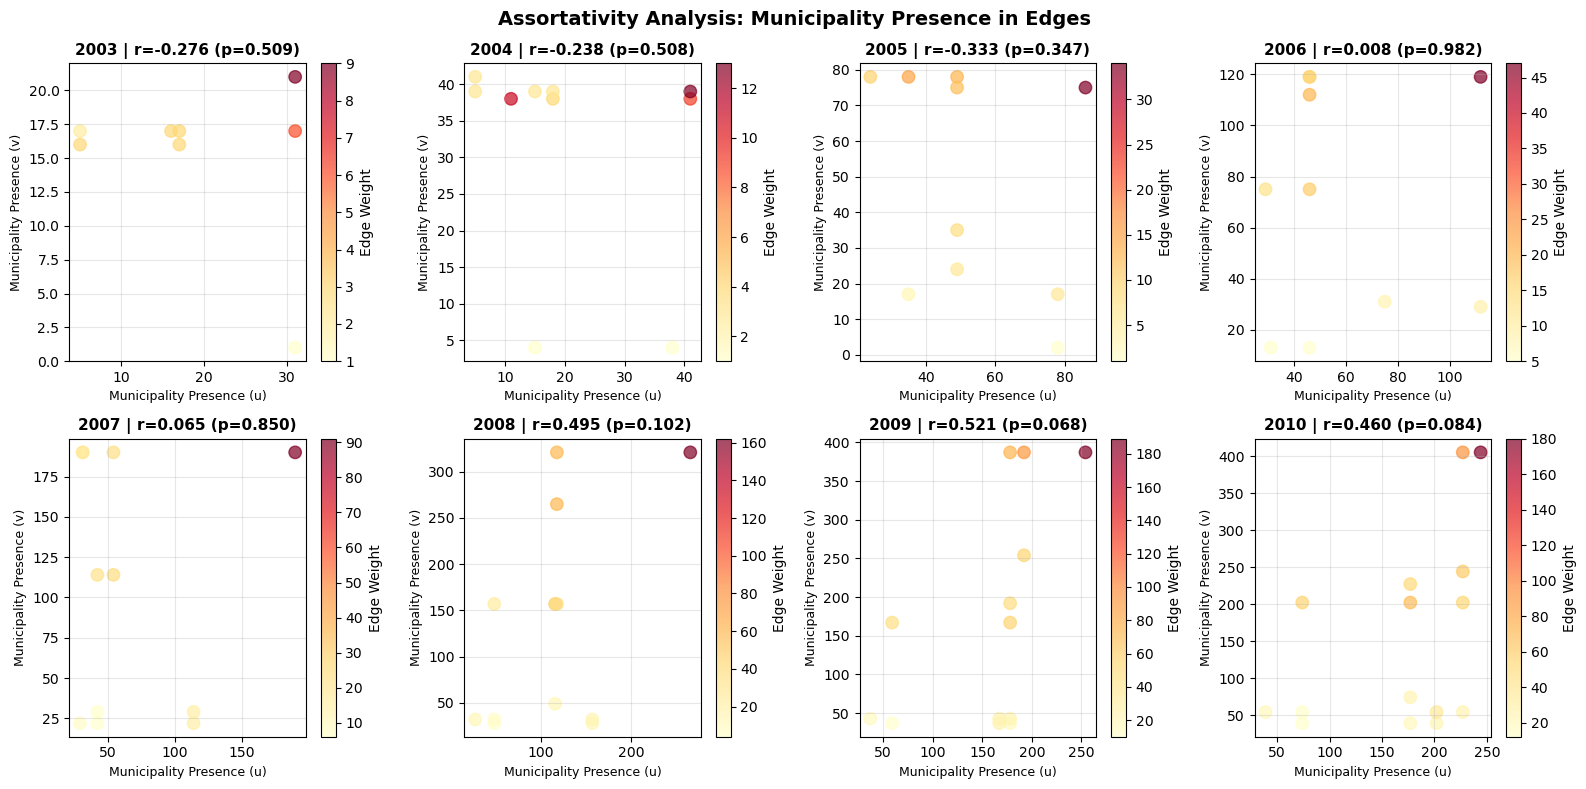

In [15]:
years_to_plot = list(range(2003, 2011))

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, year in enumerate(years_to_plot):
    ax = axes[i]
    G = G_backboned[year]
    
    
    # Extract edge data
    x_vals = []
    y_vals = []
    weights = []
    
    for u, v, w in G.edges(data='weight'):
        x_vals.append(G.nodes[u]['municipal_presence'])
        y_vals.append(G.nodes[v]['municipal_presence'])
        weights.append(w)
    
    # Plot with edge weight as color
    scatter = ax.scatter(x_vals, y_vals, c=weights, cmap='YlOrRd', 
                        alpha=0.7, s=80)

    from scipy.stats import pearsonr
    corr, p_value = pearsonr(x_vals, y_vals)
    
    # Colorbar
    plt.colorbar(scatter, ax=ax, label='Edge Weight')
    
    ax.set_xlabel('Municipality Presence (u)', fontsize=9)
    ax.set_ylabel('Municipality Presence (v)', fontsize=9)
    ax.set_title(f'{year} | r={corr:.3f} (p={p_value:.3f})', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Assortativity Analysis: Municipality Presence in Edges', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../presentation/bb_assortativity_weighted_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

By 2008-2010, a weak but consistent pattern emerges: powerful families (high municipal presence) preferentially form alliances with other powerful families.

#### **Phase 1 (2003-2007): Random Mixing**

**Evidence:**
- **r ≈ -0.3 to +0.1** (weak, inconsistent)
- **p > 0.5** (not significant)
- **3-10 edges/year**

**Pattern:**
```
Municipal presence ≠ Edge formation
→ Geography/opportunity might drive connections (haven't seen that in EDA municipality projection)
→ No preference for powerful partners
```

---

#### **Phase 2 (2008-2010): Assortative Mixing Emerges**

**Evidence:**
- **r ≈ 0.46-0.52** (moderate positive)
- **p ≈ 0.07-0.10** (borderline significant)
- **12-13 edges/year**

**Pattern:**
```
Municipal presence → Edge formation
→ Powerful families prefer powerful partners
→ "Rich get richer" consolidation
```

---

#### **Key Transition: 2007 as Filter**

**2007 war escalation:**
- Killed weak random alliances
- Survivors formed strategic partnerships
- Network shifted from exploratory → consolidated

**Visual Evidence:**
- **2003-2007:** Scattered points across all quadrants
- **2008-2010:** Upper-right clustering (powerful + powerful)

---

#### **Interpretation**

**Phase 1:** Alliances based on geographic overlap (random)  
**Phase 2:** Alliances based on strategic power matching (assortative)

**Conclusion:** War restructured networks from opportunistic to strategic.

---
# TBC: BELOW

---
### Mesoscale analysis: PLAN  
- Identification of clusters/modules (communities)
- Roles within (core) and between (bridge) communities
- Answers: "What groups exist and how are they organized?"

How to do role identification:  
1. Bridge cartels: Betweenness centrality - High values indicate bridges (many paths pass through them)
2. Community bosses: High strength centrality within communities + low betweenness (strength centrality = sum of edge weights of a node, only edges inside the community incident to a node) - strength centrality is our version of degree centrality since there are cliques inside communities  

Compare strength centralities for each node: do they really suggest there is a boss, or is it more of a decentralized community? communities will  prob be less centralized by 2004 and after 2007 there are clear bosses 

#### Community Detection
Worked!

**On BB Network first**

In [55]:
#run community detection independently per year on backboned networks
from networkx.algorithms import community

comm_dict = {'year': [], 'family': [], 'community': []}

for year, G in G_backboned.items():
    comms_in_year = community.louvain_communities(G, weight='weight', seed=42)
    
    for comm_id, comm in enumerate(comms_in_year):
        for family in comm:
                comm_dict['year'].append(year)
                comm_dict['family'].append(family)
                comm_dict['community'].append(comm_id)

df_comm_per_year = pd.DataFrame(comm_dict)

# Track community composition across all years to assign consistent colors
community_signatures = {}  # Maps frozenset of families -> color
color_idx = 0
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
                '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5']

# Build color mapping
for year in range(min_year, max_year + 1):
    year_data = df_comm_per_year[df_comm_per_year['year'] == year]
    
    for comm_id in year_data['community'].unique():
        families_in_comm = frozenset(year_data[year_data['community'] == comm_id]['family'])
        
        if families_in_comm not in community_signatures:
            community_signatures[families_in_comm] = color_palette[color_idx % len(color_palette)]
            color_idx += 1

frames = []
temp_dir = "network_frames_fixed_temp"
os.makedirs(temp_dir, exist_ok=True)

for year in range(min_year, max_year + 1):
    year_data = df_comm_per_year[df_comm_per_year['year'] == year]
    G = G_backboned[year]
    
    # Build color mapping for this year
    family_colors = {}
    for comm_id in year_data['community'].unique():
        families_in_comm = frozenset(year_data[year_data['community'] == comm_id]['family'])
        color = community_signatures[families_in_comm]
        
        for family in families_in_comm:
            family_colors[family] = color 
    
    # Plotting
    plt.figure(figsize=(10, 8))

    nx.draw_networkx_nodes(G, pos, node_color=[family_colors.get(node, '#cccccc') for node in G.nodes()], node_size=500)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

    year_edges = G.edges()
    if len(year_edges) > 0:
        year_weights = np.array(list(G.edges(data='weight')))[:,2].astype(int)
        year_weights = year_weights / max_weight * 5  # normalize for plotting
        nx.draw_networkx_edges(G, pos, edgelist=year_edges, width=year_weights, edge_color="black", alpha=1)    

    plt.title(f"Community Detection on BB Network - Year: {year}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()

    if year >= 2004:
        plt.savefig(f'../presentation/bb_communities_{year}.png', dpi=300, bbox_inches='tight')
    
    # save year plots in a temporary directory
    fname = os.path.join(temp_dir, f"frame_{year:02d}.png")
    plt.savefig(fname)
    plt.close()
    frames.append(imageio.imread(fname))

# turn all the images in the directory to a gif
imageio.mimsave('../PRESENTATION/bb_communities.gif', frames, fps=0.5)

# delete images from temporary directory
import shutil
shutil.rmtree(temp_dir)

print("Animation saved as 'bb_communities.gif'")    

C:\Users\Maribel ITU\AppData\Local\Temp\ipykernel_14820\2197781911.py:75: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(fname))


Animation saved as 'bb_communities.gif'


#### Community Strength Analysis
Testing hypothesis: Does the larger community compensate for thinner edges with more nodes/edges to compete with the Golfo-Zetas core?

In [57]:
df_comm_per_year

,year,family,community
0,1990,Beltran_Leyva,0
1,1990,Familia,1
2,1990,Golfo,2
3,1990,Juarez,3
4,1990,Sinaloa,4
...,...,...,...
163,2010,Beltran_Leyva,0
164,2010,Otros,0
165,2010,Familia,1
166,2010,Zetas,1


In [ ]:
# Calculate community strength metrics over time
community_metrics = []

for year in range(2004, max_year + 1):
    year_data = df_comm_per_year[df_comm_per_year['year'] == year]
    G = G_backboned[year]
    
    for comm_id in year_data['community'].unique():
        # Get families in this community
        families_in_comm = year_data[year_data['community'] == comm_id]['family'].tolist()
        
        # Calculate metrics for this community
        n_nodes = len(families_in_comm)
        
        # Get subgraph for this community
        community_subgraph = G.subgraph(families_in_comm)
        n_edges = community_subgraph.number_of_edges()
        
        # Calculate strength (sum of all edge weights within community)
        strength = sum(data['weight'] for u, v, data in community_subgraph.edges(data=True))
        
        # Calculate average edge weight
        avg_edge_weight = strength / n_edges if n_edges > 0 else 0
        
        # Check if Golfo and Zetas are in this community
        has_golfo_zetas = ('Golfo' in families_in_comm) and ('Zetas' in families_in_comm)
        
        community_metrics.append({
            'year': year,
            'community_id': comm_id,
            'n_nodes': n_nodes,
            'n_edges': n_edges,
            'strength': strength,
            'avg_edge_weight': avg_edge_weight,
            'has_golfo_zetas': has_golfo_zetas,
            'families': ', '.join(sorted(families_in_comm))
        })

df_community_metrics = pd.DataFrame(community_metrics)

df_community_metrics.head(20)

,year,community_id,n_nodes,n_edges,strength,avg_edge_weight,has_golfo_zetas,families,community_size
0,2004,0,4,3,16,5.333333,False,"Beltran_Leyva, Juarez, Otros, Sinaloa",Smaller
1,2004,1,4,4,22,5.500000,True,"Familia, Golfo, Tijuana, Zetas",Smaller
2,2005,0,2,1,34,34.000000,True,"Golfo, Zetas",Smaller
3,2005,1,6,8,62,7.750000,False,"Beltran_Leyva, Familia, Juarez, Otros, Sinaloa...",Smaller
4,2006,0,5,5,48,9.600000,False,"Beltran_Leyva, Juarez, Otros, Sinaloa, Tijuana",Smaller
5,2006,1,3,3,83,27.666667,True,"Familia, Golfo, Zetas",Smaller
6,2007,0,3,3,124,41.333333,True,"Familia, Golfo, Zetas",Smaller
7,2007,1,5,7,95,13.571429,False,"Beltran_Leyva, Juarez, Otros, Sinaloa, Tijuana",Smaller
8,2008,0,3,3,282,94.000000,True,"Familia, Golfo, Zetas",Smaller
9,2008,1,5,8,137,17.125000,False,"Beltran_Leyva, Juarez, Otros, Sinaloa, Tijuana",Smaller


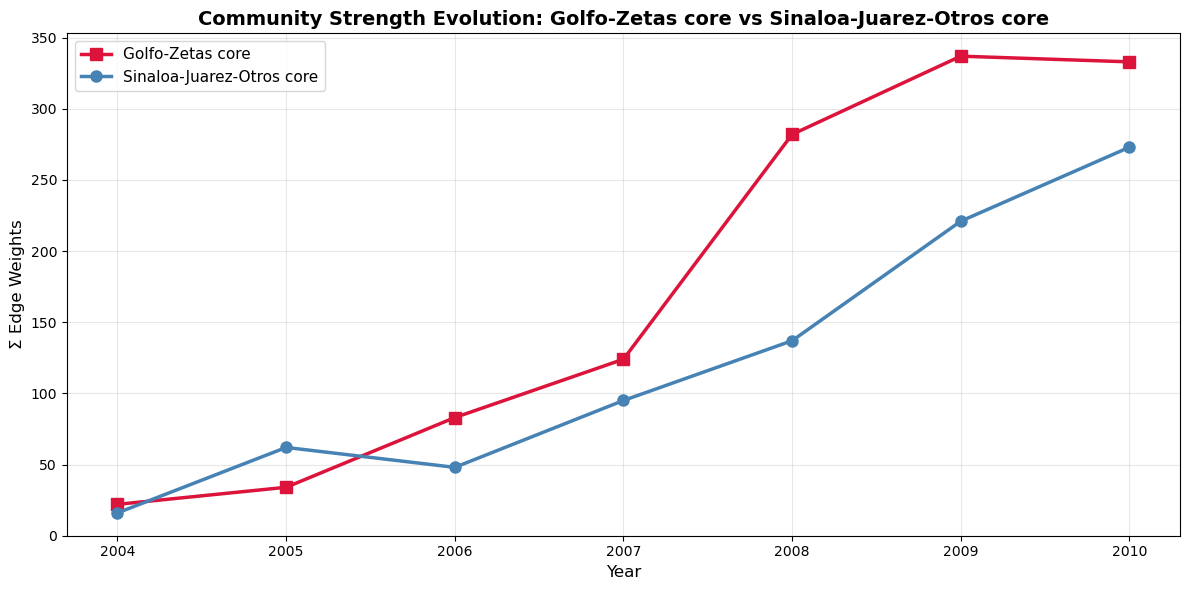

In [60]:
# Prepare data for visualization: label communities and track them over time
df_community_metrics['community_label'] = df_community_metrics['has_golfo_zetas'].apply(
    lambda x: 'Golfo-Zetas Core' if x else 'Sinaloa-Juarez-Otros Core'
)

# Plot community strength evolution
plt.figure(figsize=(12, 6))

# Separate communities by type
golfo_zetas = df_community_metrics[df_community_metrics['has_golfo_zetas'] == True]
sinaloa_otros = df_community_metrics[df_community_metrics['has_golfo_zetas'] == False]

# Plot each community
plt.plot(golfo_zetas['year'], golfo_zetas['strength'], marker='s', linewidth=2.5, 
         markersize=8, color='crimson', label='Golfo-Zetas core')
plt.plot(sinaloa_otros['year'], sinaloa_otros['strength'], marker='o', linewidth=2.5, 
         markersize=8, color='steelblue', label='Sinaloa-Juarez-Otros core')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Σ Edge Weights', fontsize=12)
plt.title('Community Strength Evolution: Golfo-Zetas core vs Sinaloa-Juarez-Otros core', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(2004, 2011))
plt.tight_layout()
plt.savefig('../presentation/bb_community_strength_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

**CD on original network to see differences**

In [ ]:
#run community detection independently per year on backboned networks
from networkx.algorithms import community

comm_dict = {'year': [], 'family': [], 'community': []}

for year, G in G_original.items():
    comms_in_year = community.louvain_communities(G, weight='weight', seed=42)
    
    for comm_id, comm in enumerate(comms_in_year):
        for family in comm:
                comm_dict['year'].append(year)
                comm_dict['family'].append(family)
                comm_dict['community'].append(comm_id)

df_comm_per_year = pd.DataFrame(comm_dict)

# Track community composition across all years to assign consistent colors
community_signatures = {}  # Maps frozenset of families -> color
color_idx = 0
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
                '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5']

# Build color mapping
for year in range(min_year, max_year + 1):
    year_data = df_comm_per_year[df_comm_per_year['year'] == year]
    
    for comm_id in year_data['community'].unique():
        families_in_comm = frozenset(year_data[year_data['community'] == comm_id]['family'])
        
        if families_in_comm not in community_signatures:
            community_signatures[families_in_comm] = color_palette[color_idx % len(color_palette)]
            color_idx += 1

frames = []
temp_dir = "network_frames_fixed_temp"
os.makedirs(temp_dir, exist_ok=True)

for year in range(min_year, max_year + 1):
    year_data = df_comm_per_year[df_comm_per_year['year'] == year]
    G = G_original[year]
    
    # Build color mapping for this year
    family_colors = {}
    for comm_id in year_data['community'].unique():
        families_in_comm = frozenset(year_data[year_data['community'] == comm_id]['family'])
        color = community_signatures[families_in_comm]
        
        for family in families_in_comm:
            family_colors[family] = color 
    
    # Plotting
    plt.figure(figsize=(10, 8))

    nx.draw_networkx_nodes(G, pos, node_color=[family_colors.get(node, '#cccccc') for node in G.nodes()], node_size=500)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

    year_edges = G.edges()
    if len(year_edges) > 0:
        year_weights = np.array(list(G.edges(data='weight')))[:,2].astype(int)
        year_weights = year_weights / max_weight * 5  # normalize for plotting
        nx.draw_networkx_edges(G, pos, edgelist=year_edges, width=year_weights, edge_color="black", alpha=1)    

    plt.title(f"Community Detection on Original Network - Year: {year}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()

    if year >= 2004:
        plt.savefig(f'../presentation/original_communities_{year}.png', dpi=300, bbox_inches='tight')
    
    # save year plots in a temporary directory
    fname = os.path.join(temp_dir, f"frame_{year:02d}.png")
    plt.savefig(fname)
    plt.close()
    frames.append(imageio.imread(fname))

# turn all the images in the directory to a gif
imageio.mimsave('../PRESENTATION/original_communities.gif', frames, fps=0.5)
# delete images from temporary directory
import shutil
shutil.rmtree(temp_dir)

print("Animation saved as 'original_communities.gif'")    

C:\Users\Maribel ITU\AppData\Local\Temp\ipykernel_14820\1454691603.py:75: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(fname))


Animation saved as 'original_communities.gif'


#### A very unsucessful multilayer network implementation to run community detection (didn't work) - IGNORE
I don't delete it because I feel bad for all the work wasted

In [16]:
# Temporal Community Detection using Supra-Graph
from util.build_supra import build_supragraph

# Build Supra-Graph (multilayer network) - NO normalization, omega in raw weight scale
omega = None  # Will set after inspecting weight distribution
G_supra = build_supragraph(G_backboned, omega=omega, normalize_weights=False, adaptive_omega=False)

print(f"Supra-graph built:")
print(f"  Nodes: {G_supra.number_of_nodes()}")
print(f"  Edges: {G_supra.number_of_edges()}")

# Count intra-layer and inter-layer edges
intra_edges = sum(1 for u, v, data in G_supra.edges(data=True) if data.get('edge_type') == 'intra')
inter_edges = sum(1 for u, v, data in G_supra.edges(data=True) if data.get('edge_type') == 'inter')

print(f"  Intra-Layer Edges: {intra_edges}")
print(f"  Inter-Layer Edges: {inter_edges}")
print(f"  Layers: {len(np.unique(np.array(G_supra.nodes())[:,1]))}")

Supra-graph built:
  Nodes: 168
  Edges: 271
  Intra-Layer Edges: 111
  Inter-Layer Edges: 160
  Layers: 21


All numbers make sense, correct implementation!  
- There's 168 nodes, 8 families in each layer x 21 layers (1990-2010)
- There's 271 edges, 160 are inter layer connecting same families in consecutive layers (20 inter layer x 8 families)
- 21 layers, corresponding with years 1990 to 2010

Let's try to choose the right omega value, I will do it in the scale of the intra layer weights across all years

Intra-layer edges: 111
  Min weight: 1.0
  Max weight: 189.0
  Mean weight: 22.5676
  Median weight: 12.0000

Inter-layer edges: 160
  Weight: None (all identical = omega)


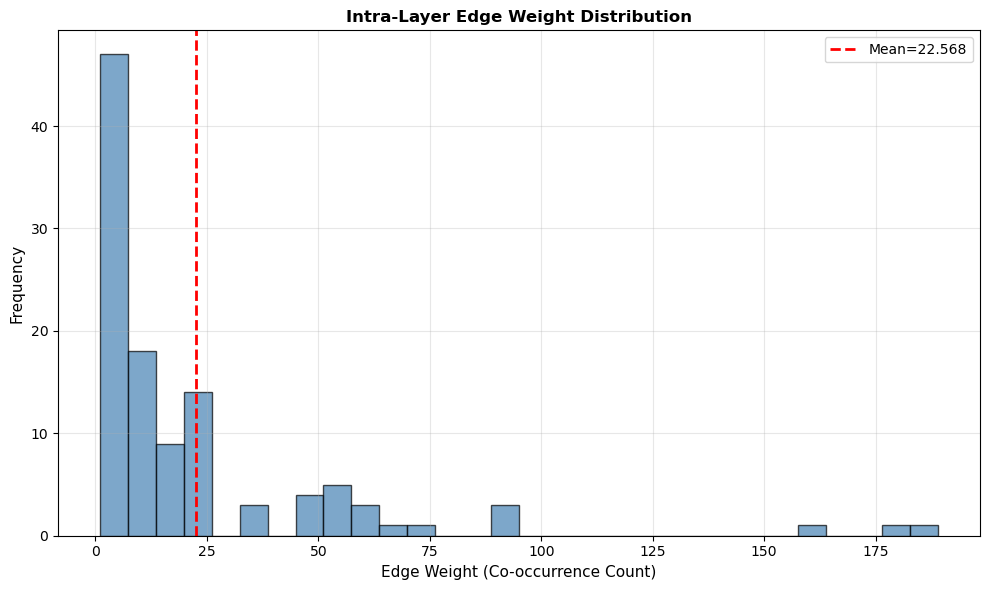


⚠️ WARNING: If omega >> mean(intra_weights), temporal continuity dominates!


In [17]:
# Inspect weight distribution in supra-graph
import matplotlib.pyplot as plt

# Separate intra-layer and inter-layer edge weights
intra_weights = []
inter_weights = []

for u, v, data in G_supra.edges(data=True):
    if data.get('edge_type') == 'intra':
        intra_weights.append(data['weight'])
    elif data.get('edge_type') == 'inter':
        inter_weights.append(data['weight'])

print(f"Intra-layer edges: {len(intra_weights)}")
print(f"  Min weight: {min(intra_weights) if intra_weights else 'N/A'}")
print(f"  Max weight: {max(intra_weights) if intra_weights else 'N/A'}")
print(f"  Mean weight: {np.mean(intra_weights) if intra_weights else 'N/A':.4f}")
print(f"  Median weight: {np.median(intra_weights) if intra_weights else 'N/A':.4f}")

print(f"\nInter-layer edges: {len(inter_weights)}")
print(f"  Weight: {inter_weights[0] if inter_weights else 'N/A'} (all identical = omega)")

# Visualize distribution
plt.figure(figsize=(10, 6))

# Histogram of intra-layer weights
plt.hist(intra_weights, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
plt.axvline(np.mean(intra_weights), color='red', linestyle='--', linewidth=2, label=f'Mean={np.mean(intra_weights):.3f}')
if omega is not None:
    plt.axvline(omega, color='orange', linestyle='--', linewidth=2, label=f'Omega={omega}')
plt.xlabel('Edge Weight (Co-occurrence Count)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Intra-Layer Edge Weight Distribution', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n⚠️ WARNING: If omega >> mean(intra_weights), temporal continuity dominates!")
# print(f"   Ratio: omega / mean(intra) = {omega / np.mean(intra_weights):.2f}x")

Choosing a single omega value for edges across layers might not be the best choice since edge weight distribution and scale changes over time, with thinner edges in early years and thicker edges in later years. Choosing omega=25might be too strong for early years, forcing a lot of community consistency but too weak for later years.

In [18]:
# Analyze weight distribution PER YEAR to see if scales differ
weight_stats_per_year = []

for year in range(min_year, max_year + 1):
    if year in G_backboned and G_backboned[year].number_of_edges() > 0:
        weights = [data['weight'] for u, v, data in G_backboned[year].edges(data=True)]
        weight_stats_per_year.append({
            'year': year,
            'min': min(weights),
            'max': max(weights),
            'mean': np.mean(weights),
            'median': np.median(weights),
            'std': np.std(weights),
            'n_edges': len(weights)
        })

df_weight_stats = pd.DataFrame(weight_stats_per_year)
print(df_weight_stats)

    year  min  max       mean  median        std  n_edges
0   1993    1    1   1.000000     1.0   0.000000        2
1   1995    2    2   2.000000     2.0   0.000000        1
2   1996    1    2   1.500000     1.5   0.500000        2
3   1997    3    3   3.000000     3.0   0.000000        1
4   1998    1    3   1.666667     1.0   0.942809        3
5   1999    1    2   1.500000     1.5   0.500000        2
6   2000    2    4   3.000000     3.0   1.000000        2
7   2001    2    4   2.600000     2.0   0.800000        5
8   2002    1    3   1.750000     1.5   0.829156        4
9   2003    1    9   3.750000     3.0   2.384848        8
10  2004    1   13   5.100000     3.0   4.060788       10
11  2005    1   34  10.800000     9.0   8.795453       10
12  2006    5   47  15.500000    14.0  11.577996       10
13  2007    6   91  22.000000    15.0  22.735635       11
14  2008    4  162  38.083333    19.5  42.076237       12
15  2009   10  189  52.461538    47.0  45.980958       13
16  2010   12 

I will pick omega = 1 for all inter layer edges until 2002. From inter layers starting on year 2002, i picked the mean weight of the layer. I set that in adaptive_omega=True inside build_supra.py

In [24]:
# Build Supra-Graph (multilayer network) - NO normalization, adaptive omega true 
G_sup = build_supragraph(G_backboned, omega=omega, normalize_weights=False, adaptive_omega=True)

print(f"Supra-graph built:")
print(f"  Nodes: {G_sup.number_of_nodes()}")
print(f"  Edges: {G_sup.number_of_edges()}")

# Count intra-layer and inter-layer edges
intra_edges = 0
inter_edges = 0
inter_layer_weights = []

for u, v, data in G_sup.edges(data=True):
    if data.get('edge_type') == 'intra':
        intra_edges += 1
    elif data.get('edge_type') == 'inter':
        inter_edges += 1
        inter_layer_weights.append(data['weight'])

print(f"  Intra-Layer Edges: {intra_edges}")
print(f"  Inter-Layer Edges: {inter_edges}")
print(f"  Layers: {len(np.unique(np.array(G_sup.nodes())[:,1]))}")

print("\nINTER-LAYER EDGE WEIGHT DISTRIBUTION (Adaptive Omega)")
print(f"Total inter-layer edges: {len(inter_layer_weights)}")
print(f"Unique omega values: {len(set(inter_layer_weights))}")
print(f"Min omega: {min(inter_layer_weights):.2f}")
print(f"Max omega: {max(inter_layer_weights):.2f}")
print(f"Mean omega: {np.mean(inter_layer_weights):.2f}")
print(f"Median omega: {np.median(inter_layer_weights):.2f}")

Supra-graph built:
  Nodes: 168
  Edges: 271
  Intra-Layer Edges: 111
  Inter-Layer Edges: 160
  Layers: 21

INTER-LAYER EDGE WEIGHT DISTRIBUTION (Adaptive Omega)
Total inter-layer edges: 160
Unique omega values: 9
Min omega: 1.00
Max omega: 52.46
Mean omega: 8.07
Median omega: 1.00


In [39]:
from networkx.algorithms import community

# Louvain community detection on supra-graph
communities_supra = community.louvain_communities(G_sup, weight='weight', seed=42)

print(f"\nCommunities detected: {len(communities_supra)}")

# Step 3: Extract communities per year
communities_per_year = {year: {} for year in range(min_year, max_year + 1)}

for comm_id, comm in enumerate(communities_supra):
    for node_tuple in comm:
        family, year = node_tuple
        year = int(year)
        if year not in communities_per_year:
            communities_per_year[year] = {}
        communities_per_year[year][family] = comm_id

# Convert to DataFrame for easier analysis
community_df = []
for year in range(min_year, max_year + 1):
    for family in families:
        comm_id = communities_per_year[year].get(family, -1)  # -1 if family not present
        community_df.append({'year': year, 'family': family, 'community': comm_id})

df_communities = pd.DataFrame(community_df)
df_communities


Communities detected: 10


,year,family,community
0,1990,Beltran_Leyva,3
1,1990,Familia,2
2,1990,Golfo,1
3,1990,Juarez,1
4,1990,Sinaloa,1
...,...,...,...
163,2010,Juarez,7
164,2010,Sinaloa,7
165,2010,Tijuana,8
166,2010,Zetas,9


I don't like the results :((((  
for years where there are literally no edges there's only 4 communities when there should be 8 communities, because there's no information in the layer to say the opposite
let's run community detection on each layer and see how communities differ from each other without previous layers information  

### Family Avoidance Analysis
Strategy: 
1. Find all pairs with the longest shortest path (maximum hops)
2. Among those, the pair with the smallest total edge weight sum = most avoiding

In [62]:
# Find the most avoiding family pairs per year
# Strategy: 
# 1. Find all pairs with maximum path length (most hops)
# 2. Among those, pick the one with smallest total edge weight sum

import networkx as nx
from itertools import combinations

avoidance_ranking = []

for year in range(2004, max_year + 1):
    G = G_backboned[year]
    
    if G.number_of_edges() == 0:
        continue
    
    # Calculate all shortest paths (in terms of hops, unweighted)
    all_pair_paths = {}
    max_path_length = 0
    
    for source in G.nodes():
        paths = nx.single_source_shortest_path(G, source)
        for target, path in paths.items():
            if source < target:  # Avoid duplicates (u,v) and (v,u)
                path_length = len(path) - 1
                all_pair_paths[(source, target)] = {
                    'path': path,
                    'hops': path_length
                }
                max_path_length = max(max_path_length, path_length)
    
    # Find all pairs with maximum path length
    max_distance_pairs = {pair: info for pair, info in all_pair_paths.items() 
                          if info['hops'] == max_path_length}
    
    # For each of these pairs, calculate the sum of edge weights along the path
    for (source, target), info in max_distance_pairs.items():
        path = info['path']
        
        # Sum edge weights along the path
        total_weight = 0
        edge_weights = []
        for i in range(len(path) - 1):
            weight = G[path[i]][path[i+1]]['weight']
            edge_weights.append(weight)
            total_weight += weight
        
        avoidance_ranking.append({
            'year': year,
            'family_1': source,
            'family_2': target,
            'path_length_hops': info['hops'],
            'total_edge_weight': total_weight,
            'avg_edge_weight': total_weight / info['hops'] if info['hops'] > 0 else 0,
            'min_edge_weight': min(edge_weights) if edge_weights else 0,
            'path': ' → '.join(path)
        })

df_avoidance_new = pd.DataFrame(avoidance_ranking)

# For each year, find the pair with maximum hops AND minimum total weight
print("MOST AVOIDING FAMILY PAIRS PER YEAR")
print("="*90)
print("Strategy: Longest path (max hops), then minimum total edge weight\n")

most_avoiding_per_year = []

for year in range(2004, max_year + 1):
    year_data = df_avoidance_new[df_avoidance_new['year'] == year].copy()
    
    if len(year_data) == 0:
        continue
    
    # Find maximum path length for this year
    max_hops = year_data['path_length_hops'].max()
    
    # Among pairs with max hops, find the one with minimum total weight
    max_hop_pairs = year_data[year_data['path_length_hops'] == max_hops]
    most_avoiding = max_hop_pairs.loc[max_hop_pairs['total_edge_weight'].idxmin()]
    
    most_avoiding_per_year.append(most_avoiding)
    
    print(f"\n{year}:")
    print("-" * 90)
    print(f"  Most Avoiding: {most_avoiding['family_1']:15} ⇔ {most_avoiding['family_2']:15}")
    print(f"  Path Length: {int(most_avoiding['path_length_hops'])} hops")
    print(f"  Total Edge Weight: {most_avoiding['total_edge_weight']:.1f}")
    print(f"  Avg Edge Weight: {most_avoiding['avg_edge_weight']:.1f}")
    print(f"  Path: {most_avoiding['path']}")
    
    # Show other max-hop pairs if they exist
    other_max_hop = max_hop_pairs[max_hop_pairs.index != most_avoiding.name]
    if len(other_max_hop) > 0:
        print(f"\n  Other pairs with {int(max_hops)} hops:")
        for idx, row in other_max_hop.head(3).iterrows():
            print(f"    • {row['family_1']:15} ⇔ {row['family_2']:15} | "
                  f"Weight: {row['total_edge_weight']:5.1f} | Path: {row['path']}")

df_most_avoiding = pd.DataFrame(most_avoiding_per_year)
df_most_avoiding

MOST AVOIDING FAMILY PAIRS PER YEAR
Strategy: Longest path (max hops), then minimum total edge weight


2004:
------------------------------------------------------------------------------------------
  Most Avoiding: Beltran_Leyva   ⇔ Tijuana        
  Path Length: 3 hops
  Total Edge Weight: 13.0
  Avg Edge Weight: 4.3
  Path: Beltran_Leyva → Sinaloa → Otros → Tijuana

  Other pairs with 3 hops:
    • Beltran_Leyva   ⇔ Familia         | Weight:  23.0 | Path: Beltran_Leyva → Sinaloa → Golfo → Familia
    • Beltran_Leyva   ⇔ Zetas           | Weight:  33.0 | Path: Beltran_Leyva → Sinaloa → Golfo → Zetas
    • Familia         ⇔ Otros           | Weight:  13.0 | Path: Familia → Golfo → Sinaloa → Otros

2005:
------------------------------------------------------------------------------------------
  Most Avoiding: Golfo           ⇔ Tijuana        
  Path Length: 4 hops
  Total Edge Weight: 57.0
  Avg Edge Weight: 14.2
  Path: Golfo → Zetas → Beltran_Leyva → Juarez → Tijuana

  Other pair

,year,family_1,family_2,path_length_hops,total_edge_weight,avg_edge_weight,min_edge_weight,path
2,2004,Beltran_Leyva,Tijuana,3,13,4.333333,1,Beltran_Leyva → Sinaloa → Otros → Tijuana
4,2005,Golfo,Tijuana,4,57,14.250000,3,Golfo → Zetas → Beltran_Leyva → Juarez → Tijuana
6,2006,Familia,Tijuana,4,50,12.500000,8,Familia → Golfo → Juarez → Sinaloa → Tijuana
8,2007,Familia,Tijuana,4,75,18.750000,13,Familia → Golfo → Beltran_Leyva → Sinaloa → Ti...
16,2008,Golfo,Tijuana,3,111,37.000000,13,Golfo → Familia → Sinaloa → Tijuana
21,2009,Golfo,Juarez,4,209,52.250000,47,Golfo → Familia → Beltran_Leyva → Sinaloa → Ju...
23,2010,Golfo,Tijuana,3,133,44.333333,20,Golfo → Familia → Beltran_Leyva → Tijuana


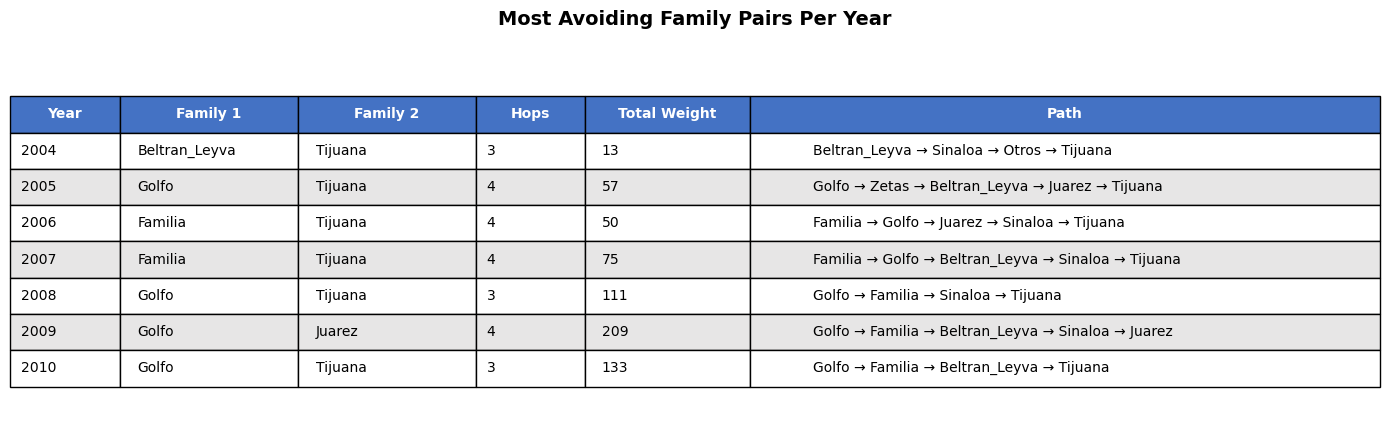

Table saved as 'bb_avoidance_table.png'


In [63]:
# Create table image for presentation
import matplotlib.pyplot as plt

# Select columns for the table
table_df = df_most_avoiding[['year', 'family_1', 'family_2', 'path_length_hops', 
                              'total_edge_weight', 'path']].copy()

# Rename columns for display
table_df.columns = ['Year', 'Family 1', 'Family 2', 'Hops', 'Total Weight', 'Path']

# Convert to values for plotting
table_data = []
for _, row in table_df.iterrows():
    table_data.append([
        int(row['Year']),
        row['Family 1'],
        row['Family 2'],
        int(row['Hops']),
        f"{row['Total Weight']:.0f}",
        row['Path']
    ])

# Create figure
fig, ax = plt.subplots(figsize=(14, len(table_data) * 0.5 + 1))
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=table_data,
                colLabels=['Year', 'Family 1', 'Family 2', 'Hops', 'Total Weight', 'Path'],
                cellLoc='left',
                loc='center',
                colWidths=[0.08, 0.13, 0.13, 0.08, 0.12, 0.46])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Header styling
for i in range(6):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(table_data) + 1):
    if i % 2 == 0:
        for j in range(6):
            table[(i, j)].set_facecolor('#E7E6E6')

plt.title('Most Avoiding Family Pairs Per Year', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../presentation/bb_avoidance_table.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Table saved as 'bb_avoidance_table.png'")

### Social Balance Theory